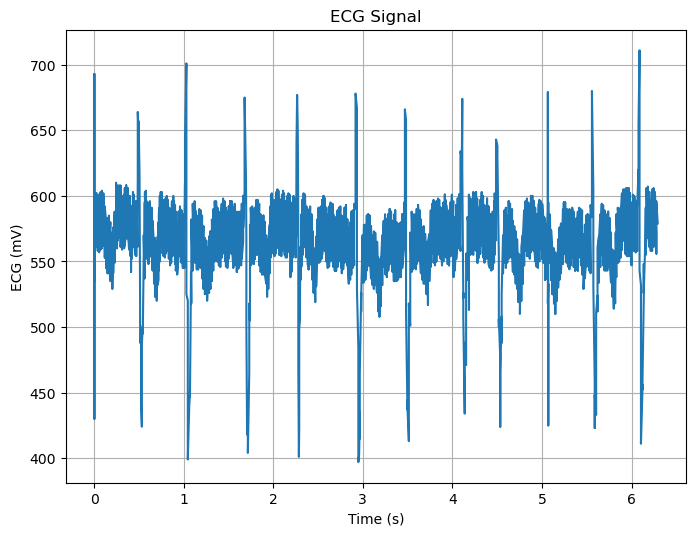

In [1]:
import serial.tools.list_ports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
import time
from scipy.signal import butter, lfilter
import neurokit2 as nk
from ecgdetectors import Detectors
import pandas as pd
import heartpy as hp
from heartpy.datautils import rolling_mean
from scipy.interpolate import interp1d
import wfdb
from wfdb import processing
import scipy.signal as sig
import math
import scipy.signal as scs
import peakutils
from numpy import genfromtxt
from scipy.signal import find_peaks
from scipy.signal import butter,filtfilt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import serial.tools.list_ports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
import time
from scipy.signal import butter, lfilter
import neurokit2 as nk
from ecgdetectors import Detectors
import pandas as pd
import heartpy as hp
from heartpy.datautils import rolling_mean
from scipy.interpolate import interp1d
import wfdb
from wfdb import processing
import scipy.signal as sig
import math
import scipy.signal as scs
import peakutils
from scipy.signal import find_peaks

namer="My_new_ECG_data_5_88bpm_9.91rpm.csv"


daty = genfromtxt(namer, delimiter=',')

# Thresholding sampling frequency distribution to remove possible infinities
init=1
thresh_samp_freq=175000
threshold=0
explode=daty.shape[0]
ecg_ref_data=daty[init:explode,1]
ecg=ecg_ref_data
timer=daty[1:(explode-init)+1,2]
inst_fs=1/np.diff(timer)
inst_fs[inst_fs > thresh_samp_freq] = threshold

# Appropiate Windowing for most narrow sampling frequency distribution
segment_length=3000
sub_segment_length=1500
err_record=[]

for i in range(len(inst_fs)-segment_length+1):
    temp_inst_fs=inst_fs[i:i+segment_length]
    err_record.append(np.std(temp_inst_fs))

val, idx = min((val, idx) for (idx, val) in enumerate(err_record))
init=idx
explode=idx+segment_length
ecg_ref_data=daty[init:explode,1]
ecg=ecg_ref_data


#Appropiate sub-windowing to find least perturbed segement, with the metric that
# if I reduce noise in the signal, then the inferred heart rate should be same.
err_record=[]
for j in range(len(ecg)-sub_segment_length+1):
    temp_ecg=ecg[j:j+sub_segment_length]
    rlocser,_ = find_peaks(temp_ecg, distance=70,height=0.5)
    n_locs_old=len(rlocser)
    length=11
    order=2
    smoothed_temp_ecg=savgol_filter(temp_ecg,length, order)
    rlocser,_ = find_peaks(smoothed_temp_ecg, distance=70,height=0.5)
    n_locs_new=len(rlocser)
    err_record.append(abs(n_locs_new-n_locs_old))

val, idx = min((val, idx) for (idx, val) in enumerate(err_record))
init=idx
explode=idx+sub_segment_length
ecg_ref_data_f=ecg[init:explode]
ecg=ecg_ref_data_f



timer=daty[1:(explode-init)+1,2]
inst_fs=1/np.diff(timer)
inst_fs[inst_fs > thresh_samp_freq] = threshold


fs_mean=np.mean(inst_fs)
fs_std=np.std(inst_fs)
fs = (np.mean(inst_fs)*6)
# fs=(fs_std)/3+fs_mean
length=11
order=7

detrended_ecg=signal.detrend(ecg)
denoised_detrended_ecg=savgol_filter(detrended_ecg,length, order)
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

b, a = butter_highpass(14/60, 10, order=2)
final_ecg = signal.filtfilt(b, a, denoised_detrended_ecg)
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)
plt.plot(timer,ecg)
plt.xlabel('Time (s)')
plt.ylabel('ECG (mV)')
plt.title('ECG Signal')
plt.grid()



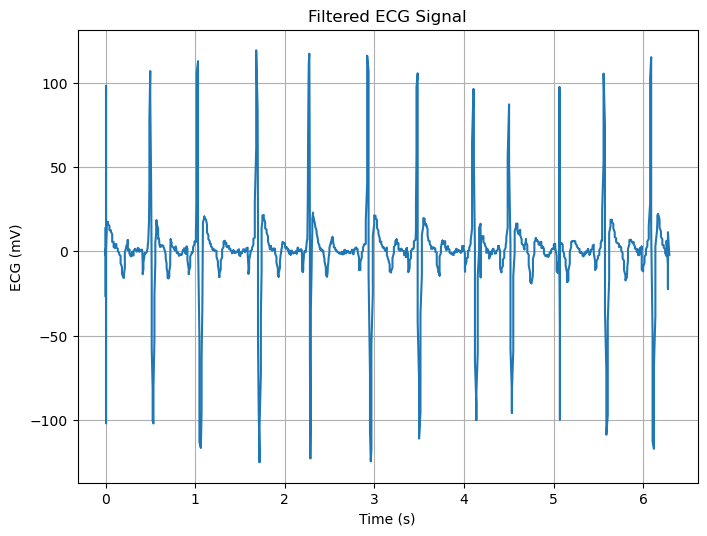

In [2]:
figure(figsize=(8, 6), dpi=100)
plt.plot(timer,final_ecg)
plt.xlabel('Time (s)')
plt.ylabel('ECG (mV)')
plt.title('Filtered ECG Signal')
plt.grid()

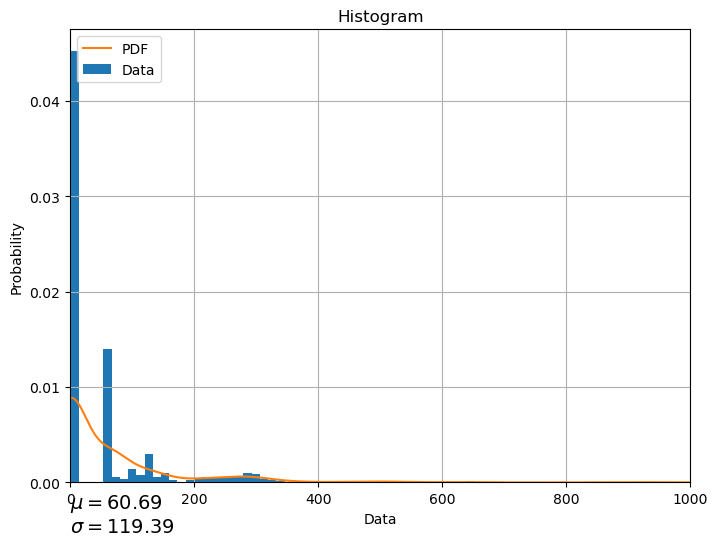

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import scipy.stats as st
figure(figsize=(8, 6), dpi=100)

# q25, q75 = np.percentile(inst_fs, [25, 75])
# bin_width = 2 * (q75 - q25) * len(inst_fs) ** (-1/3)
# bins = round((np.max(inst_fs) - np.min(inst_fs)) / bin_width)


# plt.hist(inst_fs, density=True, bins=100)
# plt.ylabel('Probability')
# plt.xlabel('Amplitude')


plt.hist(inst_fs, density=True, bins=100, label="Data")
# fs_mean=np.mean(inst_fs)
# fs_std=np.std(inst_fs)
fs_median=np.median(inst_fs)
mn=0
mx=1000
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(inst_fs)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability")
plt.xlabel("Data")
plt.title("Histogram")
textstr = '\n'.join((
    r'$\mu=%.2f$' % (fs_mean, ),
    r'$\sigma=%.2f$' % (fs_std, )))
plt.text(0.0, -0.001, textstr, fontsize=14,
        verticalalignment='top')
plt.grid()

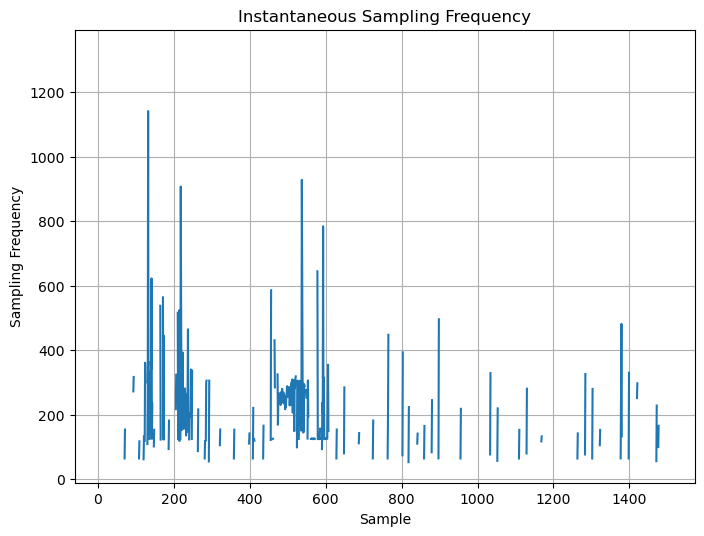

In [4]:
figure(figsize=(8, 6), dpi=100)
plt.plot(1/np.diff(timer))
plt.xlabel('Sample')
plt.ylabel('Sampling Frequency')
plt.title('Instantaneous Sampling Frequency')
plt.grid()

Method#01

In [5]:
# https://github.com/paulvangentcom/heartrate_analysis_python/blob/master/examples/2_regular_ECG/Analysing_a_regular_ECG_signal.ipynb

import math

iter=1000
init=1
bp=[]
fser=[]
for i in range(iter):
    n=np.random.rand(1)[0]
    escape=50
    lamb=2
    amp=200
    max=amp+escape
    min=amp-lamb*escape
    fs = min+n*(max-min)
    wd, m = hp.process(final_ecg, sample_rate = fs)
    l=m['breathingrate']*60
    if not math.isnan(l):
        bp.append(m['breathingrate']*60)
        fser.append(fs)

# plt.plot(fser,bp)
# plt.plot(np.array(fser),np.ones(iter)*np.mean(bp))
# plt.plot(np.array(fser),np.ones(iter)*np.mean(inst_fs))

print("RPM: ",np.mean(np.array(bp)))
print("FS: ",np.mean(np.array(fser)))

fs=np.mean(np.array(fser))

RPM:  9.689516899437924
FS:  175.6886445189184


In [25]:
ecg_rpm=[8.65,10.116,9.159,8.3087,9.689]

In [24]:
radar_rpm=[8.1161,8.2788,8.1406,8.2821,8.2521]

In [23]:
rpm=[8.06,9.3,7.42,9.61,9.91]

Error between Radar and ECG: 0.9706000000000004
Error between Manual and Radar: 0.9334599999999998
Error between Manual and ECG: 0.9567399999999996


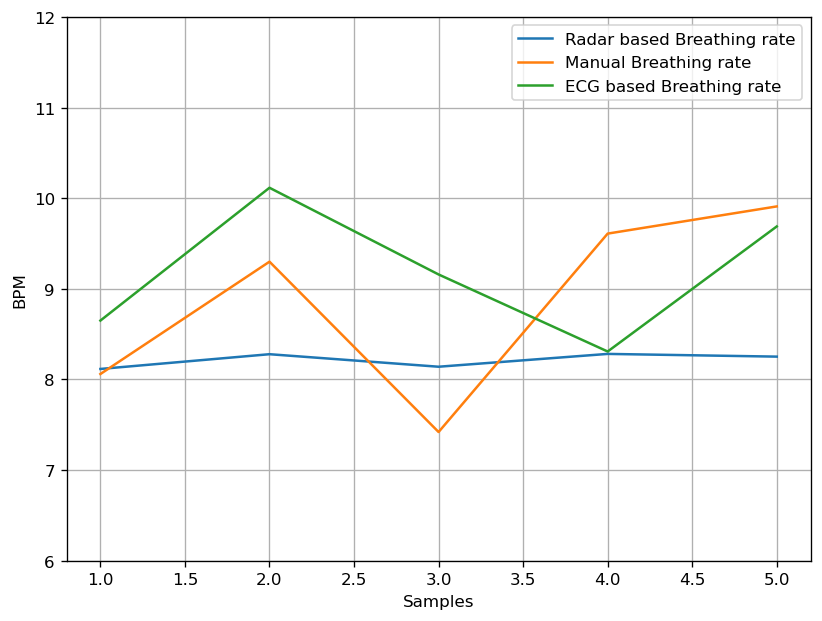

In [28]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
figure(figsize=(8, 6), dpi=120)

E1=np.mean(np.abs(np.array(rpm)-np.array(radar_rpm)))
E2=np.mean(np.abs(np.array(rpm)-np.array(ecg_rpm)))
E3=np.mean(np.abs(np.array(radar_rpm)-np.array(ecg_rpm)))
nter=list(np.arange(1,len(rpm)+1))

plt.plot(nter,radar_rpm,label='Radar based Breathing rate')
plt.plot(nter,rpm,label='Manual Breathing rate')
plt.plot(nter,ecg_rpm,label='ECG based Breathing rate')

plt.ylim(6,12)
# plt.plot(manual_res,label='Manual ECG Peak check')
plt.legend()
plt.grid()
plt.xlabel('Samples')
plt.ylabel('BPM')
# plt.title("Mean Error: "+str(E))
print("Error between Radar and ECG:",E3)
print("Error between Manual and Radar:",E2)
print("Error between Manual and ECG:",E1)
